In [44]:
import nltk
from nltk.corpus import twitter_samples
from nltk.corpus import stopwords
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy
import re
import string

import sqlite3
from sqlite3 import Error

pd.options.display.max_colwidth

#nlp packages
#remove stop words
import re
import nltk
from nltk.corpus import stopwords

This notebook will demonstrate the building of Topic Modelling on the Tweet database

In [45]:
#Step 1 - Set up connection to the database where I am storing tweets and download them;
db_file = "C:\SQLLite\Twitter_database.db"
conn = sqlite3.connect(db_file)  

#Step 2 - Pull tweets from database
df = pd.read_sql_query("SELECT * FROM tweets", conn)
df.head()

,author_id,created_at,created_at_raw,geo,tweet_id,lang,like_count,quote_count,reply_count,retweet_count,source,text,normalised_date
0,1417101905583607817,2022-02-17 18:12:29+00:00,2022-02-17T18:12:29.000Z,,1494374205537853446,en,628,3,30,218,Twitter for iPhone,Thank you @RevolutApp \n\nWelcome to #SHIBARMY...,2022-02-17 00:00:00+00:00
1,1495445778000715782,2022-02-20 17:20:11+00:00,2022-02-20T17:20:11.000Z,,1495448209887481861,en,220,0,1,126,Twitter Web App,"Superb, sobering article on shameful, systemic...",2022-02-20 00:00:00+00:00
2,28096877,2022-02-18 13:50:18+00:00,2022-02-18T13:50:18.000Z,,1494670613063024644,en,984,2,27,245,Twitter for iPhone,"To all @RevolutApp users, grab your $SHIB now ...",2022-02-18 00:00:00+00:00
3,1370977627989630976,2022-02-17 18:39:28+00:00,2022-02-17T18:39:28.000Z,,1494380997437116422,en,2387,11,143,620,Twitter Web App,.@RevolutApp just tell everyone how much you l...,2022-02-17 00:00:00+00:00
4,1474326342363537411,2022-02-23 19:13:49+00:00,2022-02-23T19:13:49.000Z,,1496563967120244741,en,0,0,0,0,Twitter for Android,@JaneDoe69086964 @JamesDelingpole @LloydsBank ...,2022-02-23 00:00:00+00:00


General analysis on the dataframe

In [46]:
df.describe(include='all')

,author_id,created_at,created_at_raw,geo,tweet_id,lang,like_count,quote_count,reply_count,retweet_count,source,text,normalised_date
count,1.745000e+04,17450,17450,17450,1.745000e+04,17450,17450.000000,17450.000000,17450.000000,17450.000000,17450,17450,17450
unique,NaN,17139,17139,189,NaN,1,NaN,NaN,NaN,NaN,79,17192,25
top,NaN,2022-02-24 18:00:30+00:00,2022-02-24T18:00:30.000Z,,NaN,en,NaN,NaN,NaN,NaN,Twitter for iPhone,@RevolutApp Done,2022-03-01 00:00:00+00:00
freq,NaN,11,11,17089,NaN,17450,NaN,NaN,NaN,NaN,7740,21,1664
mean,4.813238e+17,NaN,NaN,NaN,1.499612e+18,NaN,0.691748,0.006132,0.268596,0.124241,NaN,NaN,NaN
std,6.202511e+17,NaN,NaN,NaN,1.810740e+15,NaN,34.295569,0.153352,3.563157,5.685436,NaN,NaN,NaN
min,1.033800e+04,NaN,NaN,NaN,1.494205e+18,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
25%,2.036599e+08,NaN,NaN,NaN,1.498279e+18,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
50%,1.688174e+09,NaN,NaN,NaN,1.499449e+18,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
75%,1.184463e+18,NaN,NaN,NaN,1.501197e+18,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN


In [47]:
#PreProcessing on tweets

#Remove any rows with a "nan" in them
df = df.dropna(axis=0, how = 'any')

#Make it so that any non readable text gets converted into nothing
def removetext(text):
    return ''.join([i if ord(i) < 128 else '' for i in text])

#Here I am doing the actual removing
df['text'] = df['text'].apply(removetext)

#Function to remove  any words starting with @ from the tweets
def clean_tweet_handles(raw_tweet):
    handles_only = re.sub(r"()@\w+",r"\1",raw_tweet)
    words = handles_only.lower().split()                             
    return( " ".join( words )) 

#function to remove stop words and other punctuation
def tweet_to_words(raw_tweet):
    letters_only = re.sub("[^a-zA-Z]", " ",raw_tweet) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return( " ".join( meaningful_words )) 

#Function to get tweet length
def clean_tweet_length(raw_tweet):
    letters_only = re.sub("[^a-zA-Z]", " ",raw_tweet) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return(len(meaningful_words)) 

df['no_handles']=df['text'].apply(lambda x: clean_tweet_handles(x))
df['clean_tweet']=df['no_handles'].apply(lambda x: tweet_to_words(x))
df['Tweet_length']=df['text'].apply(lambda x: clean_tweet_length(x))


df.head()

,author_id,created_at,created_at_raw,geo,tweet_id,lang,like_count,quote_count,reply_count,retweet_count,source,text,normalised_date,no_handles,clean_tweet,Tweet_length
0,1417101905583607817,2022-02-17 18:12:29+00:00,2022-02-17T18:12:29.000Z,,1494374205537853446,en,628,3,30,218,Twitter for iPhone,Thank you @RevolutApp \n\nWelcome to #SHIBARMY...,2022-02-17 00:00:00+00:00,thank you welcome to #shibarmy! best app if yo...,thank welcome shibarmy best app never bought c...,12
1,1495445778000715782,2022-02-20 17:20:11+00:00,2022-02-20T17:20:11.000Z,,1495448209887481861,en,220,0,1,126,Twitter Web App,"Superb, sobering article on shameful, systemic...",2022-02-20 00:00:00+00:00,"superb, sobering article on shameful, systemic...",superb sobering article shameful systemic frau...,17
2,28096877,2022-02-18 13:50:18+00:00,2022-02-18T13:50:18.000Z,,1494670613063024644,en,984,2,27,245,Twitter for iPhone,"To all @RevolutApp users, grab your $SHIB now ...",2022-02-18 00:00:00+00:00,"to all users, grab your $shib now before we go...",users grab shib go moon last chance https co n...,12
3,1370977627989630976,2022-02-17 18:39:28+00:00,2022-02-17T18:39:28.000Z,,1494380997437116422,en,2387,11,143,620,Twitter Web App,.@RevolutApp just tell everyone how much you l...,2022-02-17 00:00:00+00:00,". just tell everyone how much you love $shib, ...",tell everyone much love shib love sam chief pe...,12
4,1474326342363537411,2022-02-23 19:13:49+00:00,2022-02-23T19:13:49.000Z,,1496563967120244741,en,0,0,0,0,Twitter for Android,@JaneDoe69086964 @JamesDelingpole @LloydsBank ...,2022-02-23 00:00:00+00:00,is the first ever referral based reward token ...,first ever referral based reward token bsc gai...,35


The inital ceaning is now complete - we will now import the models required for topic modelling

In [125]:
#Yopic modelling
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF

# the vectorizer object will be used to transform text to vector form
vectorizer = CountVectorizer(max_df=0.7, min_df=150)

# apply transformation
tf = vectorizer.fit_transform(df['clean_tweet']).toarray()

# tf_feature_names tells us what word each column in the matric represents
tf_feature_names = vectorizer.get_feature_names()
print(tf_feature_names)

['able', 'access', 'account', 'accounts', 'actually', 'address', 'ago', 'already', 'also', 'amp', 'another', 'answer', 'anyone', 'anything', 'app', 'ask', 'asked', 'back', 'bank', 'banking', 'banks', 'best', 'better', 'big', 'blocked', 'branch', 'business', 'buy', 'call', 'called', 'cannot', 'cant', 'card', 'cards', 'cash', 'change', 'chat', 'check', 'clear', 'close', 'closed', 'co', 'code', 'come', 'company', 'contact', 'could', 'credit', 'crypto', 'current', 'customer', 'customers', 'day', 'days', 'debit', 'declined', 'details', 'didnt', 'different', 'direct', 'dm', 'doesnt', 'done', 'dont', 'due', 'email', 'end', 'enough', 'error', 'even', 'ever', 'every', 'find', 'first', 'fraud', 'free', 'funds', 'get', 'getting', 'give', 'go', 'going', 'good', 'got', 'great', 'guys', 'hello', 'help', 'hey', 'hi', 'hold', 'hour', 'hours', 'hsbc', 'https', 'id', 'im', 'instagram', 'investors', 'issue', 'issues', 'ive', 'keep', 'know', 'last', 'let', 'like', 'line', 'lloyds', 'log', 'long', 'look', 

In [128]:
#topics
number_of_topics = 4
model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)
# model = NMF(n_components=number_of_topics, random_state=0, alpha=.1, l1_ratio=.5,max_iter=500)
model.fit(tf)

def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

In [129]:
no_top_words = 5
display_topics(model, tf_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights
0,account,2311.8,co,3564.2,please,706.8,service,865.2
1,card,1589.3,https,3469.2,thank,680.9,time,795.0
2,app,1545.0,ukraine,460.2,know,551.8,call,791.5
3,thanks,1050.9,amp,409.8,money,539.2,get,785.9
4,hi,944.2,banks,343.1,like,530.7,customer,768.8


In [130]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", model.score(tf))
# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", model.perplexity(tf))

Log Likelihood:  -521626.7577946087
Perplexity:  183.20175593383507


In [146]:
#thank welcome shibarmy best app never bought

# https://towardsdatascience.com/latent-dirichlet-allocation-for-topic-modelling-explained-algorithm-and-python-scikit-learn-c65a82e7304d
#testing the model
# @CooperativeBank why can't I access my money thru m-banking?
text7 = 'thank welcome shibarmy best app never bought'
print (model.transform(vectorizer.transform([text7])))

[[0.43932745 0.05196671 0.44665541 0.06205043]]


In [73]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", model.score(tf))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", model.perplexity(tf))

# See model parameters
print(model.get_params())

Log Likelihood:  -521626.7577946087
Perplexity:  183.20175593383507
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 4, 'n_jobs': None, 'perp_tol': 0.1, 'random_state': 0, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


In [105]:
numtopics = [2,3,4,5,10,15,20]
LOG=[]
PERP=[]
for topic in numtopics:
    model = LatentDirichletAllocation(n_components=topic, random_state=0)
    model.fit(tf)
#     print("Log Likelihood: ", model.score(tf))
#     print("Perplexity: ", model.perplexity(tf))
    LOG.append(model.score(tf))
    PERP.append(model.perplexity(tf))
    
print(LOG,PERP)
    



[-441114.86712573597, -442954.3136342085, -442300.6854111017, -442608.50465517264, -450382.4421400747, -457002.0204762215, -461721.09376334737] [141.60021722206196, 144.55524163604025, 143.49820694795685, 143.99503978979365, 157.12907776076003, 169.25302682365853, 178.46319130481893]


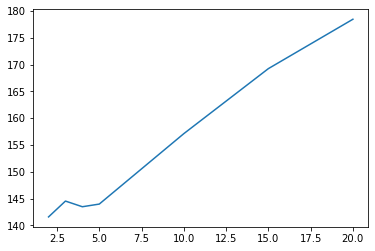

In [106]:
Index = numtopics
plt.plot(Index,PERP)

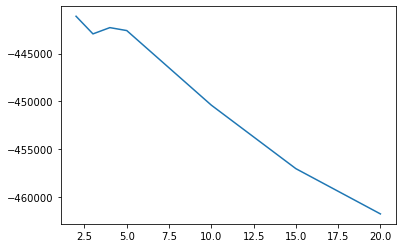

In [107]:
Index = numtopics
plt.plot(Index,LOG)